In [9]:
import gco
import cv2
import matplotlib.pyplot as plt
import numpy as np
import warnings

# load image
img1 = cv2.imread('im2.png')
img2 = cv2.imread('im6.png')

H, W = img1.shape[0:2]

# select image order
imgR = img1
imgL = img2
# imgR: in which objects are on the right in general.
# imgL: in which objects are on the left in general.

# set disparity matching direction
direction = 'RIGHT-LEFT'
# direction = 'LEFT-RIGHT';
# Please select one of them from above.
# RIGHT-LEFT: disparity searching direction is from Right to Left.
# LEFT-RIGHT: disparity searching direction is from Left to Right.

#% set parameters (class and labelcost)

# regularization of prior term 
m_lambda = 10

# set disparity range: disparity = d_min:d_max
disparity = 1:60
# Change d_max only. This should be less than image width.

# set class
m_class = np.ones([1, H*W])

# set labelcost (prior term)
[a, b] = meshgrid(disparity)
labelcost = log(((a - b).^2)./2 + 1); % log distance
# labelcost = abs(a - b); % Euclidean distance (L2)
# This can also be done using function pdist2.

# set threshold for labelcost
# threshold = max(labelcost(1, :)) / 20;
# labelcost = min(labelcost, threshold);


#% calculate (pixel-wise) disparity
unary = np.zeros(length(disparity), H*W)

for d in range( disparity):
    # fetch the left part of imgL
    imgL_left = imgL[:, 1:-d, :]
    
    # fetch the right part of imgR
    imgR_right = imgR[:, d+1:, :]
    
    # calculate the distance
    # dist = sum(abs(imgL_left - imgR_right), 3); % L1 distance
    dist = sqrt(sum((imgL_left - imgR_right).^2, 3)); # L2 distance
    
    # padding with maximum depth when there is no value to compare
    # max_depth = 255 * 3; % L1 distance
    max_depth = sqrt(255 ^ 2 * 3); % L2 distance
    if strcmp(direction, 'RIGHT-LEFT')
        dist_filled = [ones(H, d) * max_depth, dist]'
    elseif strcmp(direction, 'LEFT-RIGHT')
        dist_filled = [dist, ones(H, d) * max_depth]'

    # vectorize
    unary(d, :) = dist_filled(:)';


# set parameters (unary and pairwise)

# set unary (data term)
# Already computed.

# set upper bound for intensity level difference when computing data cost
# cutoff = 30;
# unary = min(unary, cutoff);

# set pairwise (graph structure)
pairwise = construct_graph(H, W)

# run graph cut
addpath('..\GCMex')
tic
disp('GCMex running. Takes 20 ~ 40 seconds to finish.')
[labels, ~, ~] = GCMex(class, single(unary), pairwise, single(labelcost * lambda), 1)
toc

# show original image in RGB
figure
subplot(1,2,1)
imshow(uint8(imgL))
title('Original Image (L)')
subplot(1,2,2)
imshow(uint8(imgR))
title('Original Image (R)')

# show disparity map
figure
[m, i] = min(unary);
disparity_map = reshape(i, W, H)';
imshow(uint8(disparity_map), [min(disparity), max(disparity)])
title(['Original Disparity Map (' direction ')'])

# show result
result = reshape(labels, W, H)';
figure
imshow(uint8(result), [min(disparity), max(disparity)]);
title(['Denoised Disparity Map (Unweighted graph, λ = ' num2str(lambda) ')'])



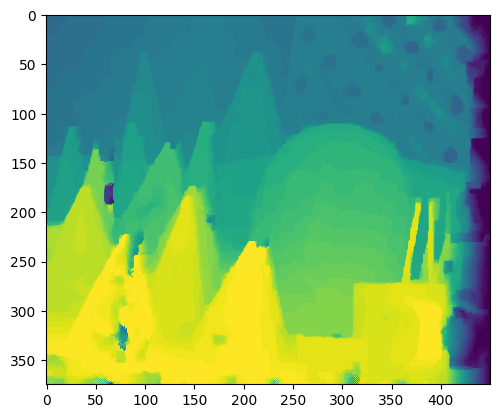

In [3]:
import gco
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import warnings

def stereoLBP(img_l, img_r, k=50, s=0.05, eta=1, iterations=20):
    H, W, C = img_l.shape
    D = np.zeros((H, W, k))
    for i in range(k):
        tmp = np.zeros((H, W, C))
        tmp[:, :W - i, :] = img_l[:, i:, :]
        D[:, :, i] = np.sum((img_r - tmp) ** 2, -1) ** 0.5
    D = D / np.max(D)

    AFFINE_DIR = {'up': np.array([[1, 0, 0], [0, 1, -1]], dtype=np.float32),
                  'down': np.array([[1, 0, 0], [0, 1, 1]], dtype=np.float32),
                  'left': np.array([[1, 0, -1], [0, 1, 0]], dtype=np.float32),
                  'right': np.array([[1, 0, 1], [0, 1, 0]], dtype=np.float32)}
    m = {'up':      np.zeros((H, W, k)),
         'down':    np.zeros((H, W, k)),
         'left':    np.zeros((H, W, k)),
         'right':   np.zeros((H, W, k))}
    h = {'up':      np.zeros((H, W, k)),
         'down':    np.zeros((H, W, k)),
         'left':    np.zeros((H, W, k)),
         'right':   np.zeros((H, W, k))}
    for _ in range(iterations):
        h_tot = D + m['up'] + m['down'] + m['left'] + m['right']
        h['up'] = cv.warpAffine(h_tot-m['down'], AFFINE_DIR['down'], dsize=(W, H))
        h['down'] = cv.warpAffine(h_tot-m['up'], AFFINE_DIR['up'], dsize=(W, H))
        h['left'] = cv.warpAffine(h_tot-m['right'], AFFINE_DIR['right'], dsize=(W, H))
        h['right'] = cv.warpAffine(h_tot-m['left'], AFFINE_DIR['left'], dsize=(W, H))
        for x in {'up', 'down', 'left', 'right'}:
            m[x] = h[x]
            for i in range(1, k):
                m[x][:, :, i] = np.minimum(m[x][:, :, i], m[x][:, :, i-1] +  s)
            for i in reversed(range(0, k-1)):
                m[x][:, :, i] = np.minimum(m[x][:, :, i], m[x][:, :, i+1] + s)

        for x in {'up', 'down', 'left', 'right'}:
            tmp = h[x].min(axis=-1, keepdims=True) + eta
            m[x] = np.minimum(m[x], tmp)
    B = np.copy(D)
    for x in {'up', 'down', 'left', 'right'}:
        B = B + m[x]
    tmp =  np.argmin(B, -1)
    res = tmp / np.max(tmp)
    return res

if __name__ == '__main__':
    img1 = cv.imread('im2.png')
    img2 = cv.imread('im6.png')
    disp = stereoLBP(img1, img2)
    plt.figure(0)
    plt.imshow( disp)




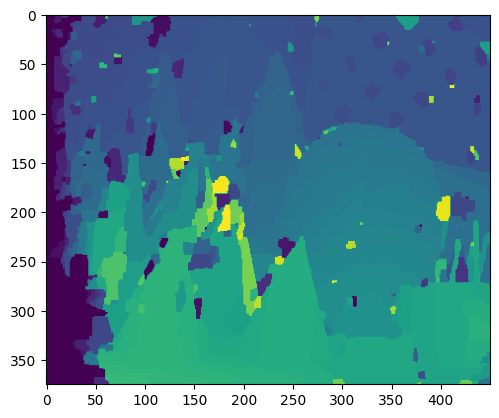

In [18]:
'''
# Part 2 Depth from Rectified Stereo Images
%
% In this part, a pair of rectified images are used to generate a disparity
% map. The disparity map is then denoised by MRF using multi-label graph
% cut.
%
% Note:
% The weights of the directed graph are 1.
% This code takes 20 ~ 40s to finish.
%
% Tunable variables:
% DISPARITY, LAMBDA, LABELCOST style, DIST style, THRESHOLD, DIRECTION
%
'''
import gco
import skimage.io as io
import numpy as np
import cv2
import matplotlib.pyplot as plt

import math


img1 = cv2.imread('im2.png')
img2 = cv2.imread('im6.png')
[H, W] = img1.shape[0:2]


# select image order
imgR = cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY)
imgL = cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY)
# imgR: in which objects are on the right in general.
# imgL: in which objects are on the left in general.

# set disparity matching direction
direction = 'RIGHT-LEFT'
# direction = 'LEFT-RIGHT'
# Please select one of them from above.
# RIGHT-LEFT: disparity searching direction is from Right to Left.
# LEFT-RIGHT: disparity searching direction is from Left to Right.

# set parameters (class and labelcost)

# regularization of prior term 
m_lambda = 1
no_disparity = 80
# set disparity range: disparity = d_min:d_max
disparity = list(range(0, no_disparity,1))

# Change d_max only. This should be less than image width.

# set class
m_class = np.ones([1, H*W])

# set labelcost (prior term)
[a, b] = np.meshgrid(disparity,disparity)


labelcost = (a - b) # log distance
smooth = (1 - np.eye(no_disparity)) *0.04
# labelcost = abs(a - b); % Euclidean distance (L2)
# This can also be done using function pdist2.

# set threshold for labelcost
# threshold = max(labelcost(1, :)) / 20;
# labelcost = min(labelcost, threshold);


## calculate (pixel-wise) disparity
unary = np.zeros([H, W, no_disparity])

for d in disparity:
    # fetch the left part of imgL
    imgL_left = imgL[:, 0:W-d]
    
    # fetch the right part of imgR
    imgR_right = imgR[:, d:W]
    
    # calculate the distance
    # dist = sum(abs(imgL_left - imgR_right), 3); % L1 distance
    dist = np.sqrt(((imgL_left - imgR_right)^2)) # L2 distance
    
    # padding with maximum depth when there is no value to compare
    # max_depth = 255 * 3; % L1 distance
    max_depth = np.sqrt(255)   #np.sqrt(255 ^ 2 * 3)  # L2 distance
    #if strcmp(direction, 'RIGHT-LEFT')
    dist_filled = np.zeros([H,W])
    dist_filled[0:H,0:d] = np.array([np.ones([H, d]) * max_depth])
    dist_filled[0:H,d:W] = dist
    #elseif strcmp(direction, 'LEFT-RIGHT')
    #    dist_filled = [dist, ones(H, d) * max_depth]';
    # vectorize
    unary[:,:, d] = dist_filled


## set parameters (unary and pairwise)

# set unary (data term)
# Already computed.

# set upper bound for intensity level difference when computing data cost
# cutoff = 30;
# unary = min(unary, cutoff);

# set pairwise (graph structure)
#pairwise = construct_graph(H, W)

# run graph cut
labels = gco.cut_grid_graph_simple(unary/255, smooth, n_iter=-1)
new_image = np.reshape(labels, imgR.shape).astype(int)


plt.figure(1)
plt.imshow(new_image.astype(int))


In [7]:
import numpy as np
a = list(range(0,10,1))
print(a)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [57]:
print(imgL)


[[ 91  89  86 ...  92 127 132]
 [104 111 123 ...  74 101 128]
 [135 150 143 ...  91  77 114]
 ...
 [156 152 149 ... 190 174 161]
 [154 154 154 ... 195 197 193]
 [152 154 161 ... 204 204 202]]


In [53]:
print(disparity)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
